In [3]:
%run ../nn_option_pricer/_key_imports.py
%run ../nn_option_pricer/nn_archi.py
%run ../nn_option_pricer/bachelier.py

In [17]:
from numpy.linalg import cholesky
from jax import grad
from jax.numpy import vectorize

N_ASSETS = 100
F = N_ASSETS
N_SAMPLES = 10**4
T = 1.0
K = 1.0

# create a covariance matrix
rng = default_rng(42)
L = 0.2 * rng.standard_normal((N_ASSETS, F))
cov = L @ L.T
assert np.linalg.det(cov) > 0
L = cholesky(cov)
w = np.ones((N_ASSETS)) / N_ASSETS


params = {
    "N_SAMPLES":N_SAMPLES,
    "N_ASSETS": N_ASSETS,
    "F": F,
    "SEED": 42,
    "T1": (30/250),
    "T": 1.0,
    "K": 1.0,
    "S0": 1.0,
    "L": L,
    "w": w
}

for i, x in enumerate([(2022, "train"), (2023, "test")]):
    seed, name = x
    start = time.time()
    params2 = params.copy()
    params2["SEED"] = seed
    X_df, WT, St = make_bachelier_dataset(**params2)
    gen_time = time.time() - start

    ## The same evaluation, if we were to use Monte-Carlo
    start = time.time()
    payoff_MC = np.zeros((N_SAMPLES))
    grad_MC = np.zeros((N_SAMPLES))
    for i in tqdm(range(N_SAMPLES)):
        payoff_MC[i] = np.mean(payoff(abm_step(St[[i], :], WT, w), params["K"]))
        grad_MC[i] = grad(lambda x, WT, w: np.mean(payoff(abm_step(x, WT, w), params["K"])))(
            St[[i], :], WT, w
        )[:, 0]

    X_df["delta_MC"] = grad_MC
    X_df["call_MC"] = payoff_MC
    MC_time = time.time() - start
    
    
    X_df.to_csv(f"datasets/bachelier_{name}.csv", index=False)
    
    print(f"Required {gen_time - start} for {params['N_SAMPLES']} samples of {params['N_ASSETS']} assets")
    print(f"MC_Time required {MC_time}")
    


  0%|          | 0/10000 [00:00<?, ?it/s]

0.2055826277478151 0.20455183160065224


  0%|          | 0/10000 [00:00<?, ?it/s]

Required -1.9073486328125e-06 for 10000 samples of 100 assets
MC_Time required 131.37102222442627


  0%|          | 0/10000 [00:00<?, ?it/s]

0.20467512101717494 0.20455183160065224


  0%|          | 0/10000 [00:00<?, ?it/s]

Required -9.5367431640625e-07 for 10000 samples of 100 assets
MC_Time required 125.47588109970093


## Evaluate Dataset Quality

In [30]:
sigma = np.sqrt(w @ L @ L.T @ w.T)
print(np.std(X_df["basket"]) / np.sqrt(params["T1"]), sigma)

0.2055826277478151 0.20455183160065224


In [27]:
X_df_train = pd.read_csv("datasets/bachelier_train.csv")

0.4998


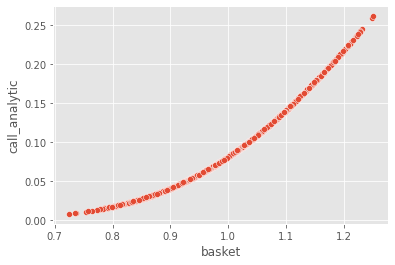

In [28]:
sns.scatterplot(X_df["basket"], X_df["call_analytic"])
intrinsic_val = np.maximum(X_df["basket"] - 1.0, 0)
print(np.mean(intrinsic_val > 0))

Text(0.5, 1.0, 'PDE error vs Strike')

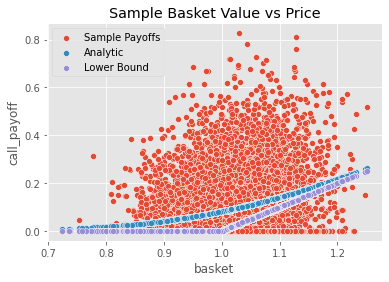

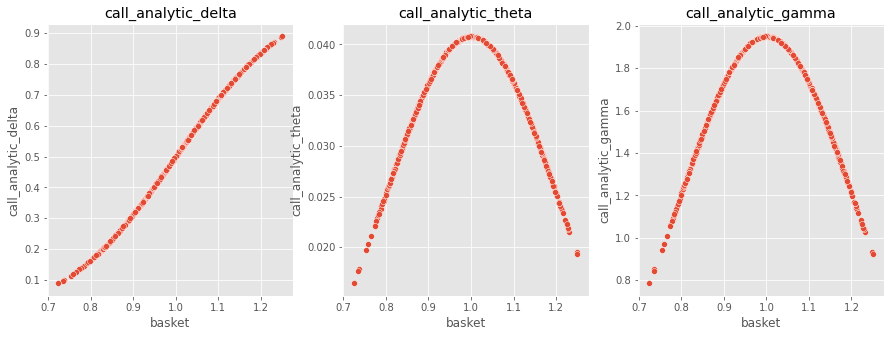

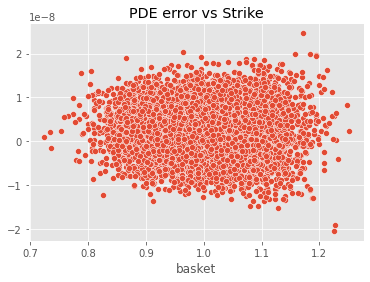

In [29]:
"""
Plot Price v Underlying
"""

fig, ax = plt.subplots()
sns.scatterplot(X_df["basket"], X_df["call_payoff"], ax=ax, label="Sample Payoffs")
sns.scatterplot(X_df["basket"], X_df["call_analytic"], ax=ax, label="Analytic")
sns.scatterplot(
    X_df["basket"], np.maximum(X_df["basket"] - K, 0), label="Lower Bound", ax=ax
)
ax.legend()
ax.set_title("Sample Basket Value vs Price")

"""
Plot Greeks
"""
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(
    ["call_analytic_delta", "call_analytic_theta", "call_analytic_gamma"]
):
    sns.scatterplot(X_df["basket"], X_df[x], ax=ax[i])
    ax[i].set_title(x)

"""
PDE Err
"""
fig, ax = plt.subplots()
PDE_err = (
    -X_df["call_analytic_theta"] + 0.5 * (sigma**2) * X_df["call_analytic_gamma"]
)
sns.scatterplot(X_df["basket"], PDE_err)
ax.set_title("PDE error vs Strike")